# Part C

In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/Documents/fin_econometrics_2/project1`


In [2]:
Pkg.instantiate()

In [3]:
include("project_functions.jl")

trainW4 (generic function with 1 method)

In [4]:
using Statistics, DataFrames, StatsPlots, TimeSeries, KernelDensity, RollingFunctions, DataFramesMeta, MarketData, Dates

## Data Preperation

In [5]:
using CSV

file_path = "/Users/sander/Documents/fin_econometrics_2/project1/aiz.csv"
aiz = CSV.File(file_path) |> DataFrame
first(aiz, 5)


5×6 DataFrame
 Row │ ret          RV         RV_p        RV_n        RS         RK      
     │ Float64      Float64    Float64     Float64     Float64    Float64 
─────┼────────────────────────────────────────────────────────────────────
   1 │  0.0120472   0.0155114  0.0125216   0.00915502   0.57316   5.09966
   2 │  0.0282087   0.0129384  0.00848344  0.00976895  -0.543282  4.25041
   3 │ -0.00291665  0.0122711  0.00972261  0.00748671   0.646612  4.3631
   4 │  0.014812    0.014421   0.011768    0.00833546   1.49139   9.69829
   5 │  0.00668774  0.0148423  0.0105351   0.0104548    0.140297  4.17256

#### HAR

Let us first consider the HAR model:
$$ RV_t = \beta_0 + \beta_1  RV_{d,t} + \beta_2  RV_{w,t} + \beta_3  RV_{m,t} + \epsilon_t $$


Hence, we will first calculate daily, weekly and monthly Realized Volatilities:

In [6]:
HAR_regressors(aiz.RV)

1478×3 Matrix{Float64}:
 0.0284341  0.0192536  0.0164559
 0.0233918  0.0204309  0.0168141
 0.0151452  0.020227   0.0169144
 0.0213311  0.0215239  0.0173262
 0.0127283  0.0202061  0.0172492
 0.0124503  0.0170093  0.0171405
 0.0149912  0.0153292  0.0169215
 0.0137577  0.0150517  0.0168273
 0.0109854  0.0129826  0.0167815
 0.0108441  0.0126057  0.0166526
 ⋮                     
 0.0171724  0.0160915  0.0137838
 0.0139953  0.0150507  0.0139307
 0.0135318  0.0149018  0.0137996
 0.0153137  0.0149716  0.0137946
 0.0188697  0.0157766  0.0140838
 0.0149667  0.0153354  0.0141763
 0.0148998  0.0155163  0.0141869
 0.0181397  0.0164379  0.0140802
 0.0147966  0.0163345  0.0140325

We can now identify the predictors and target for our study.

In [7]:
predictors = HAR_regressors(aiz.RV)
target = aiz.RV[23:end]
size(predictors), size(target)

((1478, 3), (1478,))

In [8]:
using Flux

In [9]:
xtrain = predictors[1:1000,:] |> permutedims .|> Float32
ytrain = target[1:1000] |> permutedims .|> Float32
xvalid = predictors[1001:1478,:] |> permutedims .|> Float32
yvalid = target[1001:1478] |> permutedims .|> Float32;

Note for self, the above transposes the matrices and converts the elements to 32-bit floating-point numbers.  

We now further standardize the data using ZScoreTransform.

In [10]:
using StatsBase

standardization of data:

In [11]:
fit_xt = StatsBase.fit(ZScoreTransform, log.(xtrain); dims=2, center=true, scale=true)
fit_xv = StatsBase.fit(ZScoreTransform, log.(xvalid); dims=2, center=true, scale=true)
fit_yt = StatsBase.fit(ZScoreTransform, log.(ytrain); dims=2, center=true, scale=true)
fit_yv = StatsBase.fit(ZScoreTransform, log.(yvalid); dims=2, center=true, scale=true)

ZScoreTransform{Float32, Vector{Float32}}(1, 2, Float32[-4.644698], Float32[0.33060977])

ZScoreTransform is a standardization method used to transform data into a standard normal distribution with a mean of 0 and a standard deviation of 1.

In [12]:
xt_std = StatsBase.transform(fit_xt, log.(xtrain))
xv_std = StatsBase.transform(fit_xv, log.(xvalid))
yt_std = StatsBase.transform(fit_yt, log.(ytrain))
yv_std = StatsBase.transform(fit_yv, log.(yvalid))

1×478 Matrix{Float32}:
 -0.943947  0.145748  0.869967  …  1.3257  1.92083  1.30468  0.671599

## FFNN

Now we implement the ffnn model specified in our project_functions.jl file. Note that this is the trainW3() function from the seminar with a few tweeks and changes:
- Usage of batch normalization, 
- Addition of verbose=30, maxpatience=20, drop=0.1f0, lambdaW=0.0001f0 similar to the trained model from seminar 4,
- an additional layer represented by the nodes
- different values for minimizing MSE

In [13]:
FFNN, losses11, losses12 = ffnn(xt_std, yt_std, xv_std, yv_std; nodes=[100, 50], eta=0.0001,
n_epochs=500, verbose=10, maxpatience=Inf, drop=0.1f0, lambdaW=0.0001f0);

Epoch 10 	 Loss: 1.03177 	 Test: 1.1158806
Epoch 20 	 Loss: 1.028778 	 Test: 1.2483599
Epoch 30 	 Loss: 1.028871 	 Test: 1.4479465
Epoch 40 	 Loss: 

1.0439509 	 Test: 1.5944015
Epoch 50 	 Loss: 0.9998793 	 Test: 1.5395074
Epoch 60 	 Loss: 0.9272079 	 Test: 1.3882514


Epoch 70 	 Loss: 0.8714726 	 Test: 1.2557657
Epoch 80 	 Loss: 0.83099604 	 Test: 1.1599448
Epoch 90 	 Loss: 0.7998176 	 Test: 1.0878863
Epoch 100 	 Loss: 

0.7742127 	 Test: 1.0350112
Epoch 110 	 Loss: 0.7522681 	 Test: 0.9954463
Epoch 120 	 Loss: 0.734132 	 Test: 0.9643644


Epoch 130 	 Loss: 0.7185989 	 Test: 0.93805176
Epoch 140 	 Loss: 0.70443124 	 Test: 0.9154689
Epoch 150 	 Loss: 0.69197404 	 Test: 0.89710623
Epoch 160 	 Loss: 

0.6807008 	 Test: 0.8816442
Epoch 170 	 Loss: 0.6701922 	 Test: 0.8683372
Epoch 180 	 Loss: 0.6615473 	 Test: 0.8583112


Epoch 190 	 Loss: 0.6541603 	 Test: 0.85063803
Epoch 200 	 Loss: 0.6472125 	 Test: 0.8438516


Epoch 210 	 Loss: 0.6406513 	 Test: 0.8380173
Epoch 220 	 Loss: 0.63547206 	 Test: 0.8341386
Epoch 230 	 Loss: 0.63076705 	 Test: 0.83181614
Epoch 240 	 Loss: 

0.62617 	 Test: 0.828502
Epoch 250 	 Loss: 0.62235457 	 Test: 0.82543814
Epoch 260 	 Loss: 0.619163 	 Test: 0.8231876


Epoch 270 	 Loss: 0.6164613 	 Test: 0.82187176
Epoch 280 	 Loss: 0.6137427 	 Test: 0.8199101
Epoch 290 	 Loss: 0.6112029 	 Test: 0.81849843
Epoch 300 	 Loss: 

0.60884804 	 Test: 0.81727695
Epoch 310 	 Loss: 0.60659003 	 Test: 0.816389
Epoch 320 	 Loss: 0.60453403 	 Test: 0.81563646


Epoch 330 	 Loss: 0.60261285 	 Test: 0.815167
Epoch 340 	 Loss: 0.6009456 	 Test: 0.81466657
Epoch 350 	 Loss: 0.59936726 	 Test: 0.81430215
Epoch 360 	 Loss: 

0.59788865 	 Test: 0.8137939
Epoch 370 	 Loss: 0.59641665 	 Test: 0.81345797
Epoch 380 	 Loss: 0.5949907 	 Test: 0.8136371


Epoch 390 	 Loss: 0.59341586 	 Test: 0.8132857
Epoch 400 	 Loss: 0.59195644 	 Test: 0.81329364


Epoch 410 	 Loss: 0.59065765 	 Test: 0.8140242
Epoch 420 	 Loss: 0.58942807 	 Test: 0.8145439
Epoch 430 	 Loss: 0.5882758 	 Test: 0.8149337
Epoch 440 	 Loss: 

0.5870433 	 Test: 0.81574976
Epoch 450 	 Loss: 0.5858244 	 Test: 0.816653
Epoch 460 	 Loss: 

0.5846365 	 Test: 0.81766504
Epoch 470 	 Loss: 0.5835164 	 Test: 0.8184655
Epoch 480 	 Loss: 0.58233434 	 Test: 0.8193318


Epoch 490 	 Loss: 0.58113754 	 Test: 0.8202888
Epoch 500 	 Loss: 0.58009714 	 Test: 0.8216313


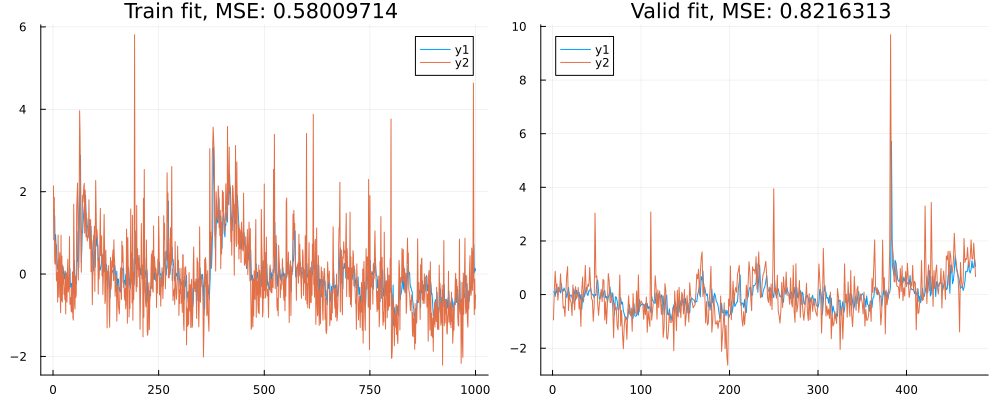

In [14]:
p1 = plot(FFNN(xt_std)', title="Train fit, MSE: $(Flux.Losses.mse(FFNN(xt_std),yt_std)) ",)
p1 = plot!(yt_std')
#
p2 = plot(FFNN(xv_std)', title="Valid fit, MSE: $(Flux.Losses.mse(FFNN(xv_std),yv_std)) ",)
p2 = plot!(yv_std');
plot(p1, p2, size=(1000, 400))

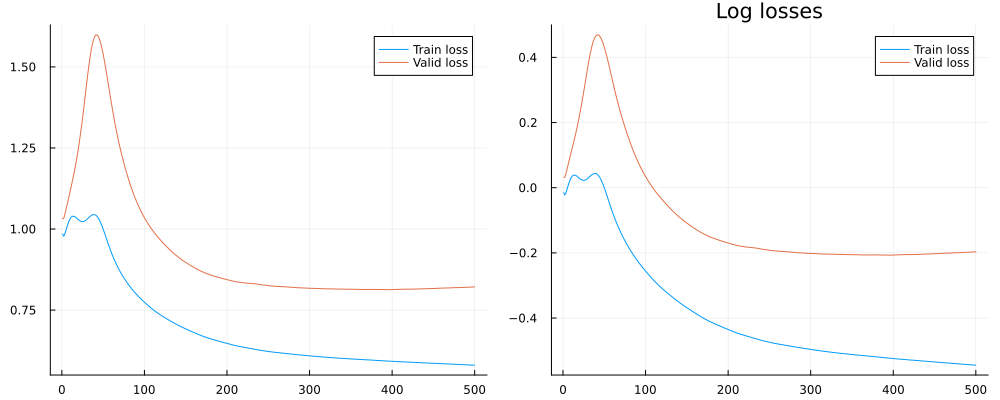

In [15]:
p11 = plot([losses11 losses12], labels=["Train loss" "Valid loss"])
p12 = plot(log.([losses11 losses12]), labels=["Train loss" "Valid loss"], title="Log losses") # might help at some cases
plot(p11, p12, size=(1000,400))

In [16]:
using Distributions

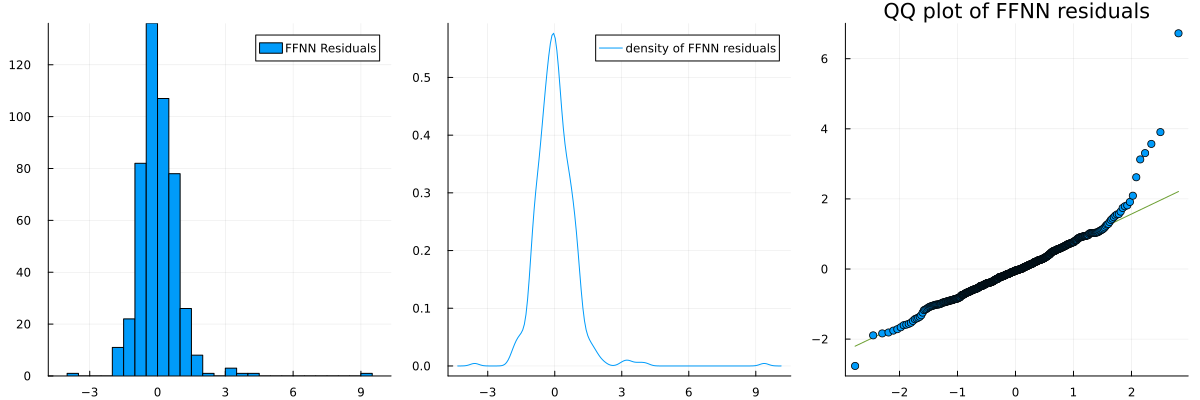

In [17]:
FFNN_resid = yv_std - FFNN(xv_std)
FFNN_quantiles = quantile(Normal(), LinRange(0, 1, length(FFNN_resid)))

qq1 = histogram(FFNN_resid', label = "FFNN Residuals")
qq2 = density(FFNN_resid', label="density of FFNN residuals")
qq3 = qqnorm(vec(FFNN_resid), qqline = :R, title = "QQ plot of FFNN residuals")
plot(qq1, qq2, qq3, layout=(1, 3), size=(1200, 400))

## RNN

In [18]:
xt_rnn = reshape(xt_std, 3, 1, :)
yt_rnn = reshape(yt_std, 1, 1, :)
xv_rnn = reshape(xv_std, 3, 1, :)
yv_rnn = reshape(yv_std, 1, 1, :);

Each "slice" along the third axis represents a sequence of length 3 for x and 1 for y, and the second dimension is used for processing elements within the sequence independently. This reshaping is often used in RNNs where the input is organized as sequences of data, and the network processes each sequence element iteratively. 

In [19]:
size(xt_std), size(yt_std)

((3, 1000), (1, 1000))

In [20]:
size(xt_rnn), size(yt_rnn)

((3, 1, 1000), (1, 1, 1000))

We now see the transformed 3D shape. 

In [21]:
mo1, mb1, lt1, lv1 = trainW4(xt_rnn, yt_rnn, xv_rnn, yv_rnn; nodes=[100, 50, 30], eta=0.001,
n_epochs=500, verbose=30, maxpatience=20, drop=0.1f0, lambdaW=0.0001f0);

Epoch [1/500] 	 Training Loss 0.81 	 Validation Loss 0.87


  ⊚ Counted +1 in patience, 1/20 	 Epoch: 3


  ⊚ Counted +1 in patience, 2/20 	 Epoch: 4


  ⊚ Counted +1 in patience, 3/20 	 Epoch: 5


  ⊚ Counted +1 in patience, 4/20 	 Epoch: 6


  ⊚ Counted +1 in patience, 5/20 	 Epoch: 7


  ⊚ Counted +1 in patience, 6/20 	 Epoch: 12


  ⊚ Counted +1 in patience, 7/20 	 Epoch: 13


  ⊚ Counted +1 in patience, 8/20 	 Epoch: 14


  ⊚ Counted +1 in patience, 9/20 	 Epoch: 20


  ⊚ Counted +1 in patience, 10/20 	 Epoch: 21


  ⊚ Counted +1 in patience, 11/20 	 Epoch: 22


  ⊚ Counted +1 in patience, 12/20 	 Epoch: 23


  ⊚ Counted +1 in patience, 13/20 	 Epoch: 24


  ⊚ Counted +1 in patience, 14/20 	 Epoch: 25


Epoch [31/500] 	 Training Loss 0.65 	 Validation Loss 0.78


  ⊚ Counted +1 in patience, 15/20 	 Epoch: 40


Epoch [61/500] 	 Training Loss 0.64 	 Validation Loss 0.77


  ⊚ Counted +1 in patience, 16/20 	 Epoch: 73


  ⊚ Counted +1 in patience, 17/20 	 Epoch: 74


  ⊚ Counted +1 in patience, 18/20 	 Epoch: 75


  ⊚ Counted +1 in patience, 19/20 	 Epoch: 76


  ⊚ Counted +1 in patience, 20/20 	 Epoch: 77
 □ Epoch 77 	 Patience is LOST :) 


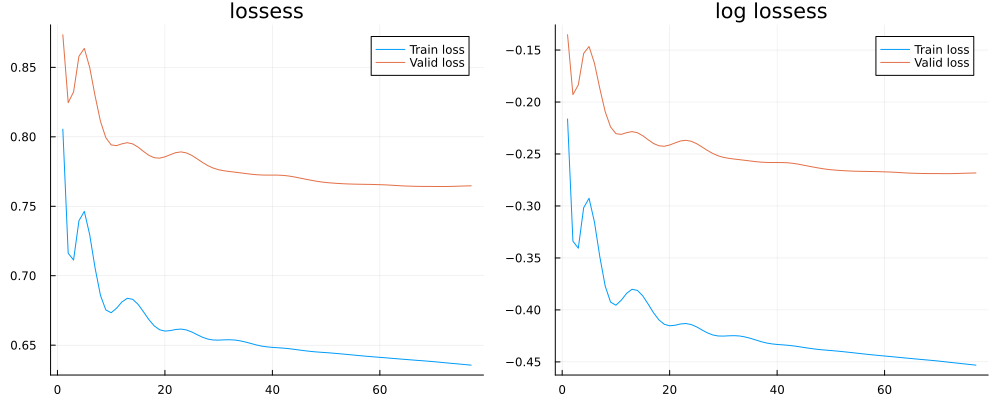

In [22]:
p3l = plot([lt1 lv1], labels=["Train loss" "Valid loss"], title = "lossess")
p4l = plot(log.([lt1 lv1]), labels=["Train loss" "Valid loss"], title = "log lossess")
plot(p3l, p4l, size=(1000,400))

In [23]:
Flux.reset!(mo1) # reset hidden
mo1(xt_rnn) # warm-up model
yhat_mo1_valid = mo1(xv_rnn) |> vec;

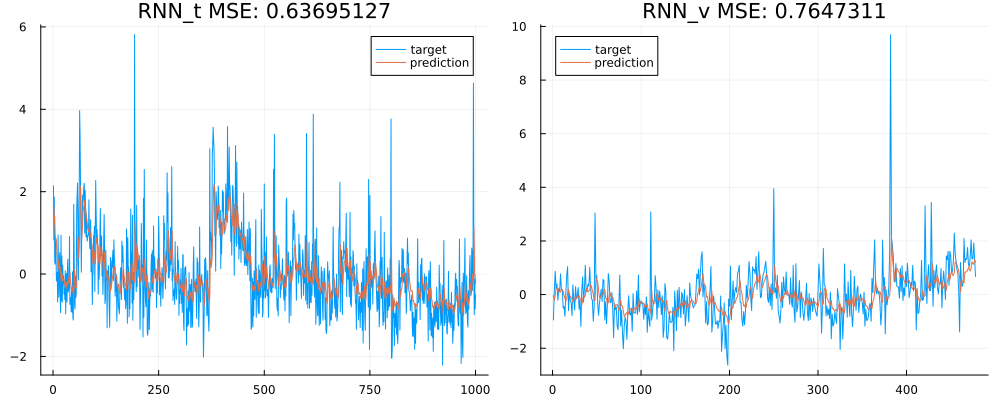

In [24]:
t_fit = mo1(xt_rnn)
plt_tld = plot(yt_rnn |> vec; label="target")
plt_tld = plot!(t_fit |> vec; label="prediction", title="RNN_t MSE: $(Flux.mse(t_fit, yt_rnn))", size = (1000,400))
pred_fit = mo1(xv_rnn)
plt_vld = plot(yv_rnn |> vec; label="target")
plt_vld = plot!(pred_fit |> vec; label="prediction", title="RNN_v MSE: $(Flux.mse(pred_fit, yv_rnn))", size = (1000,400))
plot(plt_tld,plt_vld, size = (1000,400))

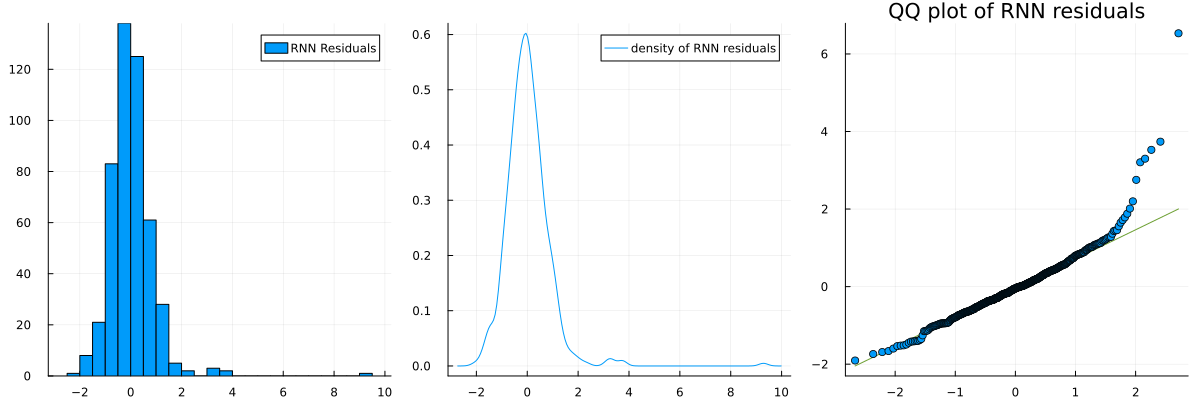

In [25]:
RNN_resid = yv_rnn .- reshape(yhat_mo1_valid, size(yv_rnn))
RNN_resid = dropdims(RNN_resid, dims=(1, 2))

qq1 = histogram(RNN_resid, label = "RNN Residuals")
qq2 = density(RNN_resid, label="density of RNN residuals")
qq3 = qqnorm(RNN_resid, qqline = :R, title = "QQ plot of RNN residuals")

plot(qq1, qq2, qq3, layout=(1, 3), size=(1200, 400))

---

## OLS

In [26]:
beta_har = OLSestimatorconst(yt_std', xt_std')

4×1 Matrix{Float64}:
 -3.882047456706694e-6
  0.2248106998945492
  0.20034621642730782
  0.2262657316061861

In [27]:
yhat_beta = [ones(size(xv_std',1)) xv_std'] * beta_har;
y_beta = [ones(size(xt_std',1)) xt_std'] * beta_har;

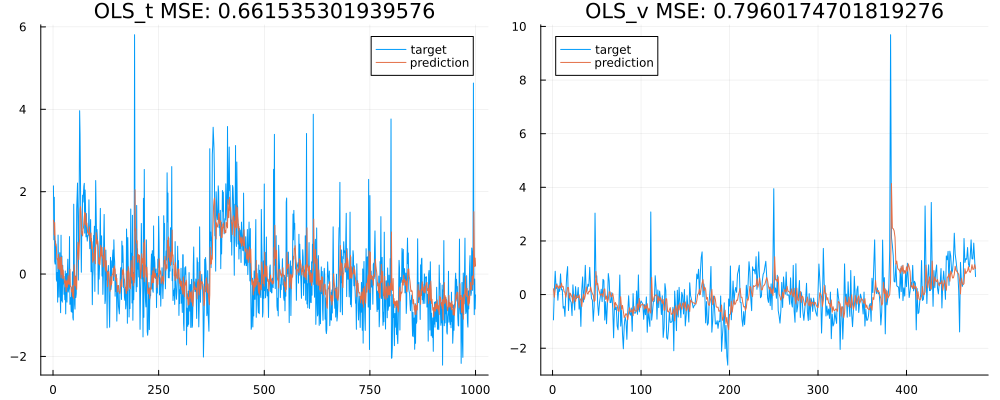

In [28]:
plt_ols_t = plot(yt_std'; label="target")
plt_ols_t = plot!(y_beta; label="prediction", title="OLS_t MSE: $(Flux.mse(y_beta, yt_std'))", size = (1000,400))
plt_ols_v = plot(yv_std'; label="target")
plt_ols_v = plot!(yhat_beta; label="prediction", title="OLS_v MSE: $(Flux.mse(yhat_beta, yv_std'))", size = (1000,400))
plot(plt_ols_t,plt_ols_v, size = (1000,400))

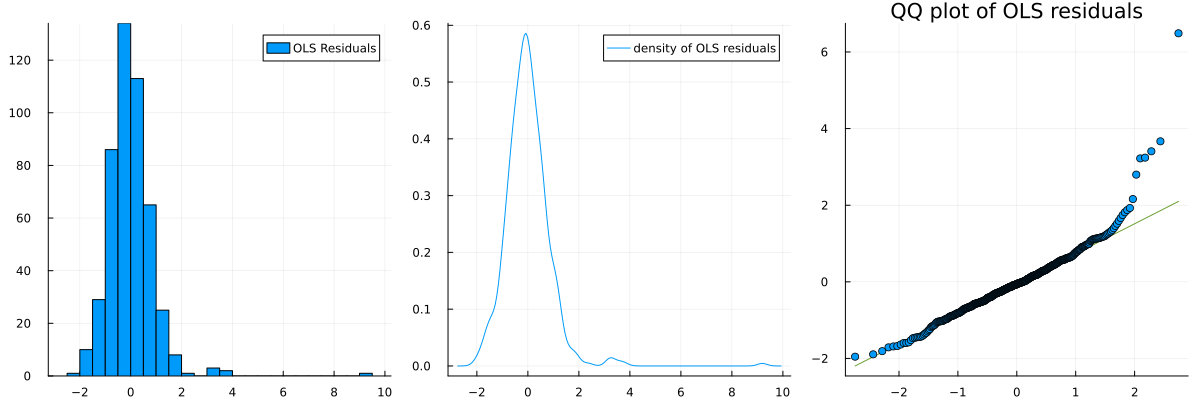

In [29]:
OLS_resid = yv_std' .- yhat_beta

qq1 = histogram(OLS_resid, label = "OLS Residuals")
qq2 = density(OLS_resid, label="density of OLS residuals")
qq3 = qqnorm(vec(OLS_resid), qqline = :R, title = "QQ plot of OLS residuals")

plot(qq1, qq2, qq3, layout=(1, 3), size=(1200, 400))

---

## Comparison

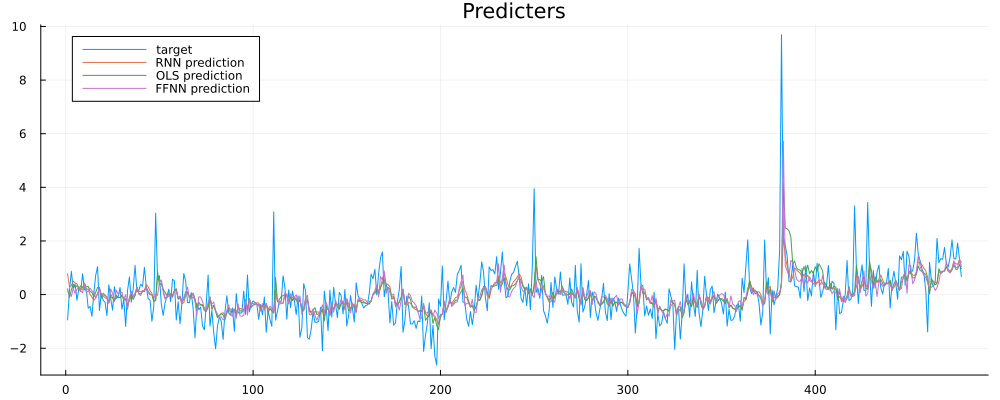

In [30]:
pred_fit = mo1(xv_rnn)
plt_vld = plot(yv_rnn |> vec; label="target")
plt_vld = plot!(pred_fit |> vec; label="RNN prediction", title="Predicters")
plt_vld = plot!(yhat_beta; label="OLS prediction", size = (1000,400))
plt_vld = plot!(FFNN(xv_std)'; label = "FFNN prediction")

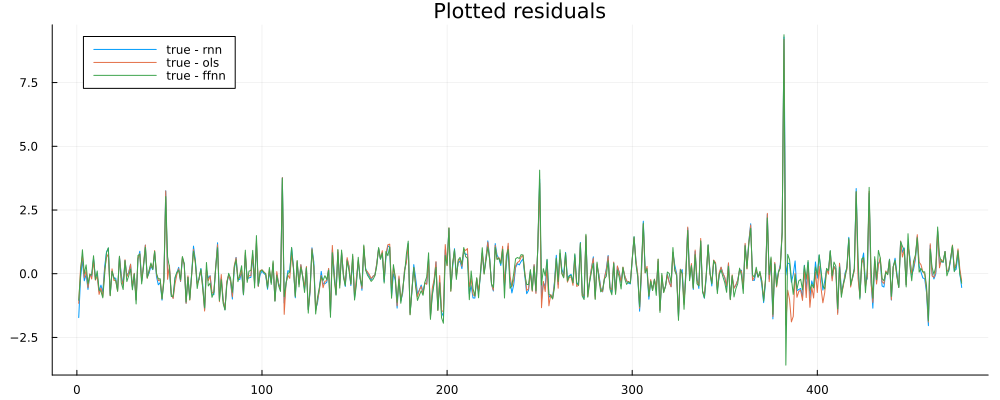

In [31]:
plot(yv_rnn[:] .- pred_fit[:], label="true - rnn")
plot!(yv_rnn[:]  .- yhat_beta, label="true - ols")
plot!(yv_rnn[:] .- FFNN(xv_std)[:], label="true - ffnn", size = (1000, 400), title = "Plotted residuals")


In [32]:
FFNN_MSE_t = Flux.Losses.mse(FFNN(xt_std),yt_std)
FFNN_MSE_v = Flux.Losses.mse(FFNN(xv_std),yv_std)
RNN_MSE_t = Flux.mse(mo1(xt_rnn), yt_rnn)
RNN_MSE_v = Flux.mse(mo1(xv_rnn), yv_rnn)
OLS_MSE_t = Flux.mse(y_beta, yt_std')
OLS_MSE_v = Flux.mse(yhat_beta, yv_std')

0.7960174701819276

In [33]:
analysis = DataFrame(
    Model = ["OLS", "FFNN", "RNN"],
    MSE_t = [OLS_MSE_t, FFNN_MSE_t, RNN_MSE_t],
    MSE_v = [OLS_MSE_v, FFNN_MSE_v, RNN_MSE_v]
)

# Display the DataFrame
display(analysis)

3×3 DataFrame
 Row │ Model   MSE_t     MSE_v    
     │ String  Float64   Float64  
─────┼────────────────────────────
   1 │ OLS     0.661535  0.796017
   2 │ FFNN    0.580097  0.821631
   3 │ RNN     0.636951  0.764731

---

## Ensemble

FFNN

In [34]:
FFNN_n_ensembles = 5
FFNN_arr_models = []
FFNN_ens_loss_t = []
FFNN_ens_loss_v = []
for iens in 1:FFNN_n_ensembles
    println("> Running ensemble $iens")
    @time FFNN0, losses01, losses02 = ffnn(xt_std, yt_std, xv_std, yv_std; nodes=[100, 50, 30], eta=0.001,
    n_epochs=500, verbose=30, maxpatience=20, drop=0.1f0, lambdaW=0.0001f0);
    # _ saving
    push!(FFNN_arr_models, FFNN0) # saving the best model for each ensemble
    push!(FFNN_ens_loss_t, losses01)
    push!(FFNN_ens_loss_v, losses02)
end

> Running ensemble 1


Stopping early. No improvement in validation loss for 20 epochs.
  0.154888 seconds (133.47 k allocations: 288.853 MiB, 32.51% gc time, 22.19% compilation time)
> Running ensemble 2


Epoch 30 	 Loss: 0.9120657 	 Test: 1.0391456
Stopping early. No improvement in validation loss for 20 epochs.
  0.135176 seconds (42.91 k allocations: 344.828 MiB, 24.08% gc time)
> Running ensemble 3
Epoch 30 	 Loss: 

0.6845717 	 Test: 0.8229807


Epoch 60 	 Loss: 0.6131855 	 Test: 0.8075776
Stopping early. No improvement in validation loss for 20 epochs.
  0.282659 seconds (102.37 k allocations: 825.325 MiB, 22.59% gc time)
> Running ensemble 4
Epoch 30 	 Loss: 

0.77270305 	 Test: 0.9077683


Epoch 60 	 Loss: 0.624323 	 Test: 0.8055795
Stopping early. No improvement in validation loss for 20 epochs.
  0.264934 seconds (97.21 k allocations: 783.543 MiB, 26.44% gc time)
> Running ensemble 5
Epoch 30 	 Loss: 

0.6674718 	 Test: 0.8543538
Stopping early. No improvement in validation loss for 20 epochs.
  0.105386 seconds (39.04 k allocations: 313.491 MiB, 24.37% gc time)


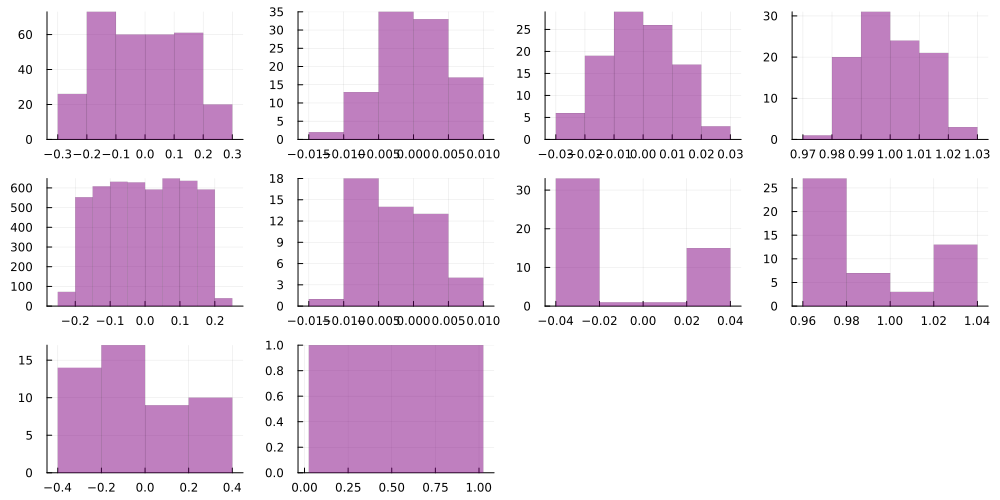

In [35]:
m_pars = Flux.params(FFNN_arr_models[1]) |> collect .|> vec
plot(histogram.(m_pars)..., line=(0), fill=(1, 0.5, :purple), legend=:none, size = (1000, 500))

In [36]:
yhat_array_FFNN = []
for m in FFNN_arr_models
    Flux.reset!(m) # reset model
    m(xt_std) # warm-up the model for time step prior prediction
    push!(yhat_array_FFNN, m(xv_std))
end
yhat_ensemble_FFNN = mean(yhat_array_FFNN) |> vec;

In [48]:
RNN_n_ensembles = 5
RNN_arr_models = []
RNN_ens_loss_t = []
RNN_ens_loss_v = []
for iens in 1:RNN_n_ensembles
    println("> Running ensemble $iens")
    @time mo0, mb0, lt0, lv0 = trainW4(xt_rnn, yt_rnn, xv_rnn, yv_rnn; nodes=[100, 50, 30], eta=0.001,
    n_epochs=500, verbose=30, maxpatience=20, drop=0.1f0, lambdaW=0.0001f0)
    # _ saving
    push!(RNN_arr_models, mb0) # saving the best model for each ensemble
    push!(RNN_ens_loss_t, lt0)
    push!(RNN_ens_loss_v, lv0)
end

> Running ensemble 1


Epoch [1/500] 	 Training Loss 0.91 	 Validation Loss 0.95


  ⊚ Counted +1 in patience, 1/20 	 Epoch: 4


  ⊚ Counted +1 in patience, 2/20 	 Epoch: 5


  ⊚ Counted +1 in patience, 3/20 	 Epoch: 6


  ⊚ Counted +1 in patience, 4/20 	 Epoch: 7


Epoch [31/500] 	 Training Loss 0.66 	 Validation Loss 0.79


Epoch [61/500] 	 Training Loss 0.64 	 Validation Loss 0.77


  ⊚ Counted +1 in patience, 5/20 	 Epoch: 77


  ⊚ Counted +1 in patience, 6/20 	 Epoch: 78


  ⊚ Counted +1 in patience, 7/20 	 Epoch: 81


  ⊚ Counted +1 in patience, 8/20 	 Epoch: 84


  ⊚ Counted +1 in patience, 9/20 	 Epoch: 85


  ⊚ Counted +1 in patience, 10/20 	 Epoch: 86


  ⊚ Counted +1 in patience, 11/20 	 Epoch: 87


  ⊚ Counted +1 in patience, 12/20 	 Epoch: 88


  ⊚ Counted +1 in patience, 13/20 	 Epoch: 89


  ⊚ Counted +1 in patience, 14/20 	 Epoch: 90


  ⊚ Counted +1 in patience, 15/20 	 Epoch: 91
Epoch [91/500] 	 Training Loss 0.63 	 Validation Loss 0.77


  ⊚ Counted +1 in patience, 16/20 	 Epoch: 92


Plotting coefficients of the first model

In [ ]:
m_pars = Flux.params(RNN_arr_models[1]) |> collect .|> vec
plot(histogram.(m_pars)..., line=(0), fill=(1, 0.5, :purple), legend=:none, size = (1000, 500))

Plot losses of all models in ensemble
Fit all models to see the output (still on validation which we use in training for stopping, for instance, thus not true Out-of-sample):

In [ ]:
yhat_array_RNN = []
for m in RNN_arr_models
    Flux.reset!(m) # reset model
    m(xt_rnn) # warm-up the model for time step prior prediction
    push!(yhat_array_RNN, m(xv_rnn))
end
yhat_ensemble_RNN = mean(yhat_array_RNN) |> vec;

HAR prediction

In [ ]:
har_coefs = OLSestimatorconst(yt_std', xt_std')
yhat_har_valid = (xv_std' * har_coefs[2:end]) .+ har_coefs[1];

In [ ]:
plot(yv_rnn |> vec, label="Target", size=(1000,400), framestyle=:box, line=(1.5, 1.0, :solid), palette=:tab10)
plot!(yhat_ensemble_RNN, label="RNN Ensemble prediction", line=(1.5, 0.8, :solid))
plot!(yhat_ensemble_FFNN, label="FFNN Ensemble prediction", line=(1.5, 0.8, :solid))
plot!(yhat_mo1_valid, label="Sigle RNN prediction", line=(1.5, 0.8, :solid))
plot!(yhat_har_valid, label="HAR OLS prediction", line=(1.5, 0.8, :solid))


In [ ]:
analysis = DataFrame(
    Model = ["OLS", "FFNN", "FFNN_ENS", "RNN", "RNN_ENS"],
    MSE_v = [OLS_MSE_v, FFNN_MSE_v, Flux.mse(yhat_ensemble_FFNN, yv_rnn |> vec), RNN_MSE_v, Flux.mse(yhat_ensemble_RNN, yv_rnn |> vec)]
)

display(analysis)

Let's see the individual predictions:

In [ ]:
ens1 = plot(yhat_array_FFNN .|> vec, framestyle=:box, line=(1, 0.7, :solid), palette=:tab10, title = "FFNN Ensemble")
ens2 = plot(yhat_array_RNN .|> vec, framestyle=:box, line=(1, 0.7, :solid), palette=:tab10, title = "RNN Ensemble")
plot(ens1, ens2, size = (1000,400))

In [ ]:
plot(yv_rnn[:]  .- yhat_ensemble_FFNN[:], label="true - FFNN Ensemble")
plot!(yv_rnn[:] .- yhat_ensemble_RNN[:], label="true - RNN Ensemble", size = (1000, 400), title = "Plotted residuals")

In [ ]:
plot(yhat_ensemble_FFNN[:] .- FFNN(xv_std)[:], label="FFNN Ensemble - FFNN Single")
plot!(yhat_ensemble_RNN[:] .- pred_fit[:], label="RNN Ensemble - RNN Single", size = (1000, 400), title = "Plotted residuals")